# Nonlinear Bar on 1D

In [1]:
using Plots, LaTeXStrings
using GaussQuadrature, LinearAlgebra, Test
using ForwardDiff
using SparseArrays, FEMSparse

struct TrussElement2{I}
    id::I
    Nodes::Vector{I}
end

struct TrussElement3{I}
    id::I
    Nodes::Vector{I}
end

struct BarInfo{T}
    E::T
    A::T
end

function meshTruss2(xL::T, xR::T, nelem::I) where {T, I}
    @assert xR > xL

    NodeDict = Dict()
    ElemDict = Dict()

    le = (xR - xL) / nelem

    for ke in 1:nelem
        NodeDict[ke] = xL + (ke-1) * le
        ElemDict[ke] = TrussElement2(ke, [ke, ke+1])
    end

    NodeDict[nelem+1] = xR
    
    return NodeDict,ElemDict
end

function assignDOFs(ElemDict::Dict)

    DOFDict = Dict()
    dof_now = 0
    
    for ke ∈ sort(collect(keys(ElemDict)))  # here just to guarantee the order is sorted
        for nodeid ∈ ElemDict[ke].Nodes
            if nodeid ∉ keys(DOFDict)
                dof_now += 1
                DOFDict[nodeid] = Dict((1=>dof_now))
            end
        end
    end
    
    return DOFDict
end

struct BarModel
    NodeDict::Dict
    ElemDict::Dict
    NSetDict::Dict
    ESetDict::Dict
    DOFDict::Dict
end

struct CellValues{T, I}
    𝐍::Vector{T}
    𝐁::Vector{T}
    xVec::Vector{T}
    ξVec::Vector{T}
    wVec::Vector{T}
    celldofs::Vector{I}
end

function celldofs!(cell_v::CellValues{T, I} ,elem::TE, DOFDict::Dict) where {TE, T, I}
    for (i, inodeid)  ∈ enumerate(elem.Nodes)
        cell_v.celldofs[i] = DOFDict[inodeid][1]
    end
    return nothing
end 

function getxcoord!(cell_v::CellValues{T, I} ,elem::TE, NodeDict::Dict) where {TE, T, I}
    for (i, inodeid)  ∈ enumerate(elem.Nodes)
        cell_v.xVec[i] = NodeDict[inodeid]
    end
    return nothing
end

function shapeFunctionL2!(N::Vector{T}, dNdξ::Vector{T}, ξ::T) where T
    # shape function and derivatives for L2 elements
    N[1] = (T(1) - ξ) / 2 
    N[2] = (T(1) + ξ) / 2

    dNdξ[1] = -T(0.5)
    dNdξ[2] =  T(0.5)
    return nothing
end 

function shapeFunctionL3!(N::Vector{T}, dNdξ::Vector{T}, ξ::T) where T
    # shape function and derivatives for L2 elements
    N[1] = ξ*(ξ - T(1))/2
    N[2] = ξ*(T(1)+ξ) /2 
    N[3] = (T(1)-ξ)*(T(1)+ξ)
    dNdξ[1] = ξ - 0.5
    dNdξ[2] = ξ + 0.5
    dNdξ[3] = - 2*ξ

    return nothing
end

function shapeFunction!(N::Vector{T}, dNdξ::Vector{T}, elem::TrussElement2, ξ::T) where {T}
    shapeFunctionL2!(N, dNdξ, ξ)
    return nothing
end
function shapeFunction!(N::Vector{T}, dNdξ::Vector{T}, elem::TrussElement3, ξ::T) where {T}
    shapeFunctionL3!(N, dNdξ, ξ)
    return nothing
end

function reinit!(cell_v::CellValues{T}, elem::TE, ξ::T) where {T, TE}
    shapeFunction!(cell_v.𝐍, cell_v.𝐁, elem, ξ)
    J = cell_v.𝐁 ⋅ cell_v.xVec
    cell_v.𝐁 ./= J
    return J
end

function compute_Kf_element!(𝐊ᵉ::Matrix{T}, 𝐟ᵉ::Vector{T}, 𝐮ᵉ::Vector{T}, cell_v::CellValues{T}, elem::TE, mat::BI) where {T, TE, BI}

    nbasefunc = length(elem.Nodes)
    n_qpoint = length(cell_v.ξVec)

    fill!(𝐊ᵉ, 0.0)
    fill!(𝐟ᵉ, 0.0)

    for q_point ∈ 1:n_qpoint

        ξ = cell_v.ξVec[q_point]
        w = cell_v.wVec[q_point]
        # !  calculate all the parameters, 𝐍, 𝐁, Jξ,
        J = reinit!(cell_v, elem, ξ)
        dΩ = J * w


        # calculate the internal nodal force
        for i in 1:nbasefunc

            F = cell_v.𝐁 ⋅ 𝐮ᵉ + 1
            ε = ( F^2 - 1 ) / 2 # Green strain 
            S = mat.E * ε   # PK2 stress 
            P = S * F   # nominal stress PK1 stress

            ∂ε∂F = F
            ∂S∂F = mat.E * ∂ε∂F
            ∂P∂F = ∂S∂F * F + S * 1

            𝐟ᵉ[i] += cell_v.𝐁[i] * P * dΩ
            # ∂F/∂uj = ∂(1+∂u∂X)/∂u = ∂(∂u∂X)/∂uJ = ∂(∑NI⋅uI)/∂uJ
            for j in 1:nbasefunc
                𝐊ᵉ[i,j] += ( 
                            cell_v.𝐁[i] * ∂P∂F * cell_v.𝐁[j] 
                        )* dΩ
            end
        end
    end
    return nothing
end

function compute_fb_element!(𝐟ᵉ::Vector{T}, cell_v::CellValues{T}, elem::TE, b::T) where {T, TE}

    nbasefunc = length(elem.Nodes)
    n_qpoint = length(cell_v.ξVec)
    
    for q_point ∈ 1:n_qpoint
        ξ = cell_v.ξVec[q_point]
        w = cell_v.wVec[q_point]
        J = reinit!(cell_v, elem, ξ)
        dΩ = J * w
        for i in 1:nbasefunc
            𝐟ᵉ[i] += cell_v.𝐍[i] * b * dΩ
        end
    end
    return nothing
end


function Initial_Kf(BarModel::BarModel, cell_v::CellValues)

    totaldof = ndofs(BarModel.DOFDict)
    nbasefunc = length(cell_v.𝐍)

    𝐊ᵉ = ones(nbasefunc, nbasefunc)
    𝐟ᵉ = ones(nbasefunc)

    𝕂 = SparseMatrixCOO()
    𝕗  = zeros(totaldof)

    for (kelem, elem) in BarModel.ElemDict
        celldofs!(cell_v, elem, BarModel.DOFDict)
        𝕗[cell_v.celldofs] .+= 𝐟ᵉ
        add!(𝕂, cell_v.celldofs, cell_v.celldofs, 𝐊ᵉ)
    end

    𝕂 = SparseMatrixCSC(𝕂)

    𝕂.nzval .= 0.0
    𝕗 .= 0.0

    return 𝕂, 𝕗
end

function Assemble_Kf!(𝕂::SparseMatrixCSC, 𝕗::Vector{T}, 𝕦::Vector{T},
                BarModel::BarModel, cell_v::CellValues, mat::BI, b::T) where {T, BI}

    nbasefunc = length(cell_v.𝐍)

    𝐊ᵉ = zeros(nbasefunc, nbasefunc)
    𝐟ᵉ = zeros(nbasefunc)
    𝐮ᵉ = zeros(nbasefunc)

    fill!(𝕂, 0.0)
    fill!(𝕗, 0.0)
    
    assembler = FEMSparse.start_assemble(𝕂, 𝕗)

    for (kelem, elem) in BarModel.ElemDict

        celldofs!(cell_v, elem, BarModel.DOFDict)
        getxcoord!(cell_v,elem, BarModel.NodeDict)
        𝐮ᵉ .= 𝕦[cell_v.celldofs]

        compute_Kf_element!(𝐊ᵉ, 𝐟ᵉ, 𝐮ᵉ, cell_v, elem, mat)
        compute_fb_element!(𝐟ᵉ, cell_v, elem, b)
        
        FEMSparse.assemble_local!(assembler, cell_v.celldofs, 𝐊ᵉ, 𝐟ᵉ)
    end

    return nothing
end

function apply_bc!(𝕂, 𝕗, fem_model, setname, dof, val)

    ndof = size(𝕗,1)

    for nodeid in fem_model.NSetDict[setname]
        _dof = fem_model.DOFDict[nodeid][dof]
        K_temp = 𝕂[_dof,_dof]
        𝕂[_dof,:] .= 0.0
        𝕂[_dof,_dof] = K_temp
        for _kdof in 1:ndof
            𝕗[_kdof] -= 𝕂[_kdof,_dof]*val
            𝕂[_kdof,_dof] = 0.0
        end
    end
    return nothing
end
function apply_bc!(𝕦, fem_model, setname, dof, val)

    for nodeid in fem_model.NSetDict[setname]
        _dof = fem_model.DOFDict[nodeid][dof]
        𝕦[_dof] = val
    end
    return nothing
end

function apply_zero_bc!(𝕂, 𝕗, fem_model, setname, dof)
    for nodeid in fem_model.NSetDict[setname]
        _dof = fem_model.DOFDict[nodeid][dof]
        K_temp = 𝕂[_dof,_dof]
        𝕂[_dof,:] .= 0.0
        𝕂[:,_dof] .= 0.0
        𝕂[_dof,_dof] = K_temp
        𝕗[_dof] = 0.0
    end
    return nothing 
end
function apply_zero_bc!(𝕦, fem_model, setname, dof)

    ndof = size(𝕦,1)

    for nodeid in fem_model.NSetDict[setname]
        _dof = fem_model.DOFDict[nodeid][dof]
        𝕦[_dof] = 0.0
    end
    return nothing
end

function ndofs(DOFDict::Dict)
    ndof = 0
    for (nodeid, dofs) in DOFDict
        ndof += length(dofs)
    end
    return ndof
end

ndofs (generic function with 1 method)

In [2]:
x_l = 0.0
x_r = 1.0
n_elem = 10

b = 0.0
Ebar = 70000.0
Abar = 2.0

barmat = BarInfo(Ebar, Abar)

NodeDict, ElemDict = meshTruss2(x_l, x_r, n_elem)
DOFDict = assignDOFs(ElemDict)

NSetDict = Dict()
NSetDict["Left"] = [1]
NSetDict["Right"] = [n_elem+1]
ESetDict = Dict()

BarModel_2 = BarModel(NodeDict, ElemDict, NSetDict, ESetDict, DOFDict)

ξVec, wVec = legendre(2)
cell_v = CellValues(zeros(2),zeros(2),zeros(2),ξVec, wVec, zeros(Int64,2))

𝕦g  = zeros(ndofs(BarModel_2.DOFDict))
δ𝕦g = zeros(ndofs(BarModel_2.DOFDict))
𝕂g, 𝕗g = Initial_Kf(BarModel_2, cell_v)

RF = []

for kinc = 1:100

    u̅ = 0.01*kinc
    δ𝕦g .= 0.0

    apply_zero_bc!(𝕂g, 𝕗g, BarModel_2, "Left", 1)
    apply_bc!(𝕂g, 𝕗g, BarModel_2, "Right", 1, u̅)
    apply_bc!(𝕦g, BarModel_2, "Right", 1, u̅)
    
    for kiter = 1:100
        if kiter == 100
            warn("reach the maximum iteration number, abort")
        end
        
        Assemble_Kf!( 𝕂g, 𝕗g, 𝕦g, BarModel_2, cell_v, barmat, b)
        RF_temp = 𝕗g[BarModel_2.DOFDict[BarModel_2.NSetDict["Right"][1]][1]]

        apply_zero_bc!(𝕂g, 𝕗g, BarModel_2, "Left" , 1)
        apply_zero_bc!(𝕂g, 𝕗g, BarModel_2, "Right", 1)

        δ𝕦g .= -  𝕂g \ 𝕗g

        apply_zero_bc!(δ𝕦g, BarModel_2, "Left" , 1 )
        apply_zero_bc!(δ𝕦g, BarModel_2, "Right", 1 )

        𝕦g .+= δ𝕦g

        if norm(δ𝕦g) < 1e-11
            push!(RF, RF_temp)
            break 
        end
    end

end




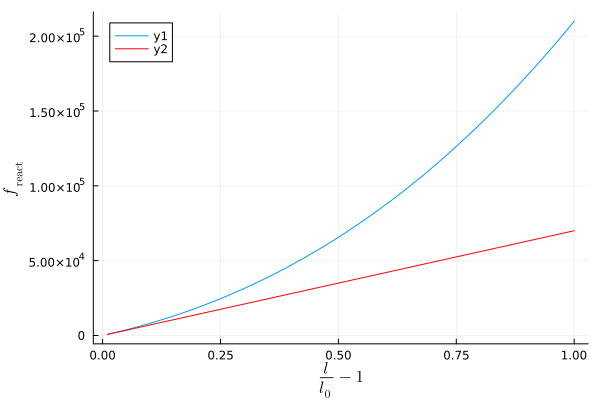

In [5]:
plt1 = plot(collect(0.01:0.01:1.0),RF)
plot!(plt1, collect(0.01:0.01:1.0), barmat.E*collect(0.01:0.01:1.0), color=:red)
xlabel!(plt1, L"\frac{l}{l_0}-1")
ylabel!(plt1, L"f_\mathrm{react}")
# plt2 = plot(log.(collect(0.01:0.01:1.0).+1.0),RF)
# plot(plt1, plt2)